In [0]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil

try:
    shutil.rmtree("fer13")
except Exception:
    pass

In [0]:
from zipfile import ZipFile 

file_name = "drive/My Drive/final_u1.zip"
  
with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall("fer13")
    print('Done!')

Extracting all the files...
Done!


In [0]:
import os
import cv2
import dlib
import math
import joblib
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [0]:
np.random.seed(42)

In [0]:
INPUT_PATH = "fer13/final/"
PLOTS_PATH = "drive/My Drive/FER/Colab/GauravSharma/plots/"
MODEL_PATH = "drive/My Drive/FER/Colab/GauravSharma/models/"

In [0]:
class_count = {}
for dir_ in os.listdir(INPUT_PATH):
    if not dir_.isupper():
        os.rename(INPUT_PATH+dir_, INPUT_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Angry has 966 number of images
Fear has 859 number of images
Happy has 2477 number of images
Sadness has 1326 number of images
Neutral has 1446 number of images

total images are 7074


In [0]:
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

5249

In [0]:
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(INPUT_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_label = np_utils.to_categorical(img_label)
img_arr.shape, img_label

loaded all Happy images to numpy arrays
loaded all Sadness images to numpy arrays
loaded all Neutral images to numpy arrays


((5249, 48, 48, 1), array([0., 0., 0., ..., 2., 2., 2.]))

In [0]:
label_to_text

{0: 'Happy', 1: 'Sadness', 2: 'Neutral'}

In [0]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 0, 'Neutral': 2, 'Sadness': 1}

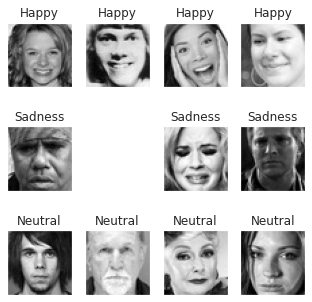

In [0]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
img_arr = img_arr / 255.

In [0]:
%%time

print("extracting facial landmarks, this may take some time...")

face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(MODEL_PATH+"dumps/shape_predictor_68_face_landmarks.dat")

facial_landmarks = []
count = 0

for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img = cv2.imread(INPUT_PATH + dir_ + "/" + f, 0)
            img_ = cv2.resize(img, (96,96))
            img_ = cv2.equalizeHist(img_)

            faces = face_detector(img_)
            
            if faces:
                for face in faces:
                    landmarks = shape_predictor(img_, face)
                    landmarks_coords = []
                    for i in range(0, 68):
                        landmarks_coords.append((landmarks.part(i).x, landmarks.part(i).y))
                    facial_landmarks.append(landmarks_coords)
            else:
                count += 1
                facial_landmarks.append([(0,0)]*68)

print(f"\ntotal images with no facial landmarks: {count},\t fraction: {count/len(facial_landmarks)}")

facial_landmarks = np.array(facial_landmarks)
print("facial landmarks", facial_landmarks.shape)

print("\n")

extracting facial landmarks, this may take some time...
processing Happy images...
processing Sadness images...
processing Neutral images...

total images with no facial landmarks: 960,	 fraction: 0.18289197942465232
facial landmarks (5249, 68, 2)


CPU times: user 14 s, sys: 296 ms, total: 14.3 s
Wall time: 14.4 s


In [0]:
%%time

print("extracting HOG features, this will take few minutes...")

hog_features = []
hog_images = []

for dir_ in os.listdir(INPUT_PATH):    
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for i,f in enumerate(os.listdir(INPUT_PATH + dir_ + "/")):
            img = imread(INPUT_PATH + dir_ + "/" + f, as_gray=True)
            resized_img = resize(img, (128,64))

            hog_feat, hog_img = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(2, 2), visualize=True, multichannel=False)

            hog_features.append(hog_feat)
            hog_images.append(hog_img)


hog_features = np.array(hog_features)
print("\nhog feature", hog_features.shape)

hog_images = np.array(hog_images)
print("hog image", hog_images.shape)

print("\n")

extracting HOG features, this will take few minutes...
processing Happy images...
processing Sadness images...
processing Neutral images...

hog feature (5249, 3780)
hog image (5249, 128, 64)


CPU times: user 3min 35s, sys: 2min 34s, total: 6min 10s
Wall time: 3min 8s


In [0]:
Xtrain_img, Xtest_img, Xtrain_fl, Xtest_fl, Xtrain_hogfeat, Xtest_hogfeat, Xtrain_hogimg, Xtest_hogimg, y_train, y_test = \
train_test_split(img_arr, facial_landmarks, hog_features, hog_images, img_label,
                shuffle=True, stratify=img_label, train_size=0.88, random_state=42)

print(Xtrain_img.shape, Xtrain_fl.shape, Xtrain_hogfeat.shape, Xtrain_hogimg.shape, y_train.shape)
print(Xtest_img.shape, Xtest_fl.shape, Xtest_hogfeat.shape, Xtest_hogimg.shape, y_test.shape)

(4619, 48, 48, 1) (4619, 68, 2) (4619, 3780) (4619, 128, 64) (4619, 3)
(630, 48, 48, 1) (630, 68, 2) (630, 3780) (630, 128, 64) (630, 3)


In [0]:
def dcnn_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_DCNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_img'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_img')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_img'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_img')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_img')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_img')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_img'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_img')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_img'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_img')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_img')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_img')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_img'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_img')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_img'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_img')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_img')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_img')(maxpool2d_3)

    flatten = Flatten(name='flatten_dcnn_img')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_dcnn_img'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_img')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_img')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def facial_landmarks_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_Facial_Landmarks")
    flatten = Flatten(name="flatten_fl")(model_in)
    dense1 = Dense(64, activation="relu", name="dense1_fl")(flatten)
    model_out = Dropout(0.4, name='dropout1_fl')(dense1)
    
    return model_in, model_out

In [0]:
def facial_HOGimg_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_HOGimg")

    flatten = Flatten(name='flatten_cnn_hogimg')(model_in)

    dense_1 = Dense(
        512,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_cnn_hogimg'
    )(flatten)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_hogimg')(dense_1)
    
    model_out = Dropout(0.5, name='dropout_1_hogimg')(batchnorm_1)

    return model_in, model_out

In [0]:
def facial_HOGfeat_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_HOGfeat")
    dense1 = Dense(256, activation="elu", name="dense1_hogfeat")(model_in)
    model_out = Dropout(0.4, name='dropout1_hogfeat')(dense1)
    return model_in, model_out

In [0]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.3, name='dropout1_merged')(concated)

    dense1 = Dense(128, activation="elu", name="dense1_merged")(dropout_1)
    dropout_2 = Dropout(0.5, name='dropout2_merged')(dense1)

    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_2)

    model = Model(inputs=models_in, outputs=out, name="FER_Model")

    if show_summary:
        model.summary()
    
    return model

In [0]:
dcnn_in, dcnn_out = dcnn_pipeline(input_shape=(48,48,1))
fl_in, fl_out = facial_landmarks_pipeline(input_shape=(68,2))
hogimg_in, hogimg_out = facial_HOGimg_pipeline(input_shape=(128,64,1))
hogfeat_in, hogfeat_out = facial_HOGfeat_pipeline(input_shape=(3780))

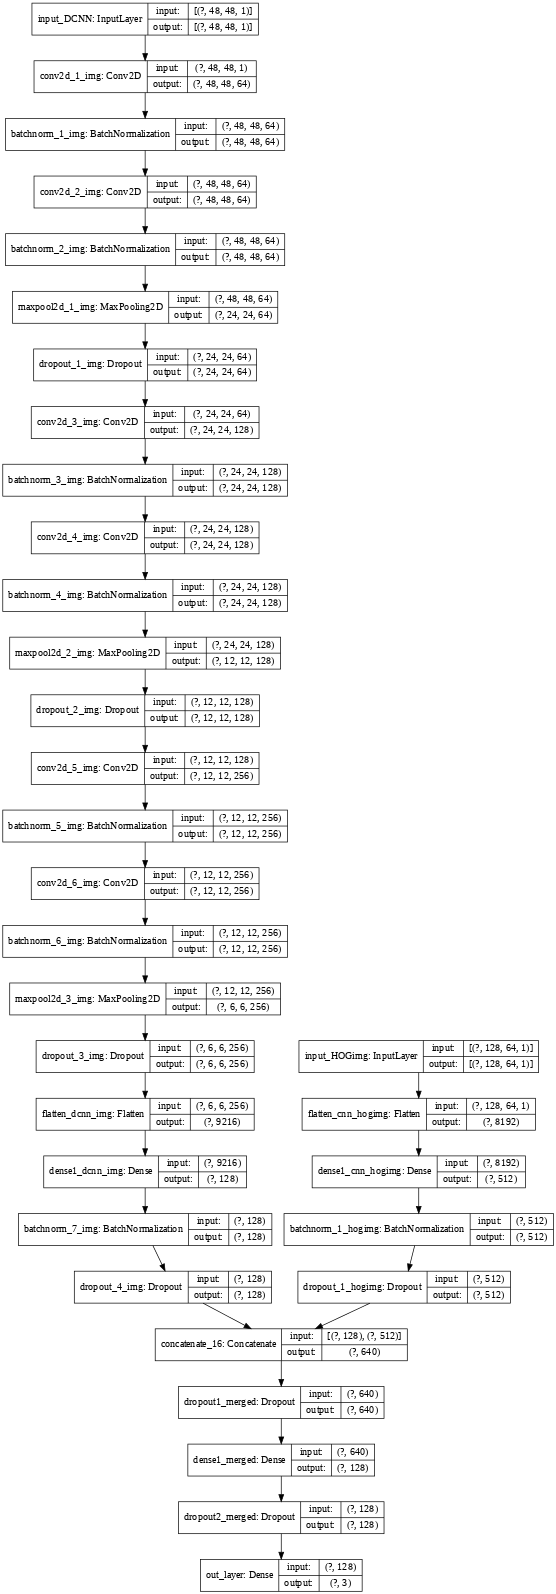

In [0]:
models_in = [dcnn_in, hogimg_in]
models_out = [dcnn_out, hogimg_out]

num_classes = y_train.shape[1]
num_pipes = len(models_in)

model = merge_models(
    models_in=models_in,
    models_out=models_out,
    num_classes=num_classes,
)

model_name = "dcnn+hogimg"
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50, to_file=PLOTS_PATH+f'model_architecture/{model_name}_model.png')

In [0]:
def data_generator(Xtrain_img, Xtrain_hogimg, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        batches = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], Xtrain_hogimg[idx[ idx0:idx1 ]] ], batch[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00008,
    factor=0.3,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [0]:
batch_size = 12
epochs = 75
lr = 0.01
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    data_generator(Xtrain_img, Xtrain_hogimg, y_train, batch_size=batch_size,),
    validation_data=([Xtest_img, Xtest_hogimg], y_test),
    steps_per_epoch=len(Xtrain_img) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/75
385/384 [==============================] - 7s 18ms/step - loss: 1.7911 - accuracy: 0.4951 - val_loss: 0.8991 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 2/75
385/384 [==============================] - 7s 17ms/step - loss: 1.0405 - accuracy: 0.5270 - val_loss: 0.9810 - val_accuracy: 0.5095 - lr: 0.0100
Epoch 3/75
385/384 [==============================] - 7s 18ms/step - loss: 1.0806 - accuracy: 0.5124 - val_loss: 1.0063 - val_accuracy: 0.5460 - lr: 0.0100
Epoch 4/75
385/384 [==============================] - 7s 18ms/step - loss: 1.0741 - accuracy: 0.5036 - val_loss: 0.9736 - val_accuracy: 0.5270 - lr: 0.0100
Epoch 5/75
385/384 [==============================] - 7s 18ms/step - loss: 1.1019 - accuracy: 0.5116 - val_loss: 0.9660 - val_accuracy: 0.5413 - lr: 0.0100
Epoch 6/75
383/384 [============================>.] - ETA: 0s - loss: 1.0904 - accuracy: 0.4917
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
385/384 [==============================] - 7

In [0]:
model_yaml = model.to_yaml()
with open(MODEL_PATH+f"yamls/{model_name}_{num_classes}emo.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save(MODEL_PATH+f"dumps/{model_name}_{num_classes}emo.h5")

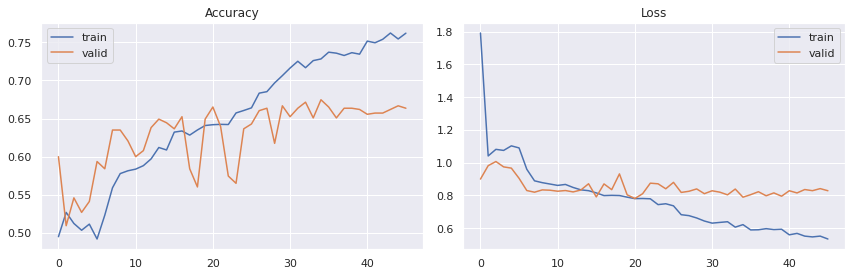

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(PLOTS_PATH + f'epoch_metrics/{model_name}_{num_classes}emo.png')
pyplot.show()

In [0]:
label_to_text, text_to_label

({0: 'Happy', 1: 'Sadness', 2: 'Neutral'},
 {'Happy': 0, 'Neutral': 2, 'Sadness': 1})

test accuracy: 67.4603 %


              precision    recall  f1-score   support

           0       0.79      0.85      0.82       297
           1       0.49      0.61      0.54       159
           2       0.68      0.43      0.53       174

    accuracy                           0.67       630
   macro avg       0.65      0.63      0.63       630
weighted avg       0.68      0.67      0.67       630



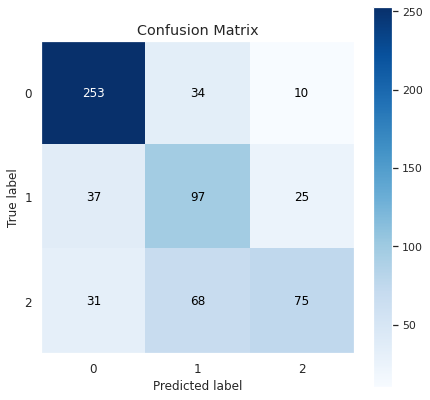

In [0]:
yhat_test = model.predict([Xtest_img, Xtest_hogimg])
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(PLOTS_PATH + f'confusion_matrix/{model_name}_{num_classes}emo.png')

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))